# SETTINGS

In [1]:
############ LIBRARIES

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
%matplotlib inline

import os
import time
import random
import multiprocessing
import pickle

import scipy.stats

import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
############ HELPER FUNCTIONS

import functions
import importlib
importlib.reload(functions)
from functions import *

In [3]:
############ RANDOMNESS

# seed function
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 23
seed_everything(seed)

# DATA PREPARATION

In [4]:
# import CSV
df = pd.read_pickle('../input/data_v9.pkl')
print(df.shape)

(1097231, 511)


In [5]:
# target variable
target = 'isFraud'

In [6]:
# partitioning
full_train = df[df[target].isnull() == False].reset_index(drop = True)
full_test  = df[df[target].isnull() == True].reset_index(drop = True)
print(full_train.shape)
print(full_test.shape)
del df

(590540, 511)
(506691, 511)


In [7]:
# group indicator
full_train['group'] = 1
full_test['group']  = 1
full_train.loc[full_train.id_01.isnull(), 'group'] = 0
full_test.loc[full_test.id_01.isnull(),   'group'] = 0
print(full_train['group'].value_counts())
print(full_test['group'].value_counts())

0    446307
1    144233
Name: group, dtype: int64
0    364784
1    141907
Name: group, dtype: int64


# MODELING

### PARAMETERS

In [8]:
############ FEAUTERS

# drop bad features
excluded_feats = ['isFraud',
                  'TransactionID', 'TransactionDT',
                  'bank_type',
                  'uid1', 'uid2', 'uid3', 'uid4', 'uid5', 
                  'DT', 'DT_D', 'DT_W', 'DT_M', 'DT_hour', 
                  'DT_day_week', 'DT_day_month', 
                  'DT_D_total', 'DT_W_total', 'DT_M_total']
full_features = [f for f in full_train.columns if f not in excluded_feats]
print(full_train[full_features].shape)

(590540, 505)


In [9]:
############ PARAMETERS

# cores
cores = 24

# cross-validation
num_folds = 6
shuffle   = True

# number of trees
max_rounds = 10000
stopping   = 200
verbose    = 250

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'binary',
    'metric':            'auc',
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.01,
    'max_depth':         5,
    'num_leaves':        100,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}

lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':cores,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':max_rounds,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': seed,
                } 

# data partitinoing
#folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)
folds = GroupKFold(n_splits = num_folds)

# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = seed, n_jobs = cores, sampling_strategy = 0.1)

In [10]:
############ PLACEHOLDERS

# placeholders
clfs = []
importances = pd.DataFrame()

# predictions
preds_test = np.zeros(full_test.shape[0])
preds_oof  = np.zeros(full_train.shape[0])

### CROSS-VALIDATION

In [11]:
cv_start  = time.time()
for pcd in full_train.group.unique():
    
    print('-'*15)
    print('-'*15)
    print('GROUP = ' + str(pcd))
    print('-'*15)
    print('-'*15)
    
    train = full_train[full_train.group == pcd]
    test  = full_test[full_test.group   == pcd]

    idx1 = train.index
    idx2 = test.index
        
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop  = True, inplace = True)
    
    y = train[target]
    del train[target], test[target]
    
    features = full_features.copy()
    for var in train.columns:
        if train[var].isnull().sum() == len(train):
            del train[var], test[var]
            if var in features:
                features.remove(var)


    ############ CROSS-VALIDATION LOOP
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y, groups = train['DT_M'])):

        # data partitioning
        trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
        val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
        test_x       = test[features]

        # label encoding
        trn_x, val_x, test_x = label_encoding(trn_x, val_x, test_x)

        # print data dimensions
        print('Data shape:', trn_x.shape, val_x.shape)

        # train lightGBM
        clf = lgb.LGBMClassifier(**lgb_params) 
        clf = clf.fit(trn_x, trn_y, 
                      eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                      eval_metric           = 'auc', 
                      early_stopping_rounds = stopping,
                      verbose               = verbose)
        clfs.append(clf)

        # find the best iteration
        best_iter = clf.best_iteration_

        # save predictions
        preds_oof[idx1[val_idx]] = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
        preds_test[idx2]        += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 

        # importance
        fold_importance_df               = pd.DataFrame()
        fold_importance_df['Feature']    = features
        fold_importance_df['Importance'] = clf.feature_importances_
        fold_importance_df['Fold']       = n_fold + 1
        importances                      = pd.concat([importances, fold_importance_df], axis = 0)

        # print performance
        print('--------------------------------')
        print('FOLD%2d: AUC = %.6f' % (n_fold + 1, roc_auc_score(y[val_idx], preds_oof[idx1[val_idx]])))
        print('--------------------------------')
        print('')

        # clear memory
        del trn_x, trn_y, val_x, val_y
        gc.collect()


    # print overall performance    
    cv_perf = roc_auc_score(y, preds_oof[idx1])
    print('--------------------------------')
    print('- OOF AUC = %.6f' % cv_perf)
    print('--------------------------------')
    
    
print('CV TIME = {:.2f} min'.format((time.time() - cv_start) / 60))

---------------
---------------
GROUP = 0
---------------
---------------
Data shape: (363654, 412) (82653, 412)
Training until validation scores don't improve for 200 rounds.
[250]	training's auc: 0.989614	valid_1's auc: 0.894327
[500]	training's auc: 0.999746	valid_1's auc: 0.908873
[750]	training's auc: 0.999995	valid_1's auc: 0.913249
[1000]	training's auc: 1	valid_1's auc: 0.915736
[1250]	training's auc: 1	valid_1's auc: 0.91653
Early stopping, best iteration is:
[1266]	training's auc: 1	valid_1's auc: 0.91662
--------------------------------
FOLD 1: AUC = 0.916620
--------------------------------

Data shape: (367844, 412) (78463, 412)
Training until validation scores don't improve for 200 rounds.
[250]	training's auc: 0.988531	valid_1's auc: 0.878845
[500]	training's auc: 0.999666	valid_1's auc: 0.891047
[750]	training's auc: 0.999991	valid_1's auc: 0.895557
[1000]	training's auc: 0.999999	valid_1's auc: 0.897046
[1250]	training's auc: 1	valid_1's auc: 0.897659
Early stopping, b

### EVALUATION

In [12]:
############ RECHECK PERFORMANCE  

# check performance
y = full_train[target]
print(np.round(roc_auc_score(y, preds_oof), 5))
cv_perf = roc_auc_score(y, preds_oof)


############ TRACK RESULTS


0.9389


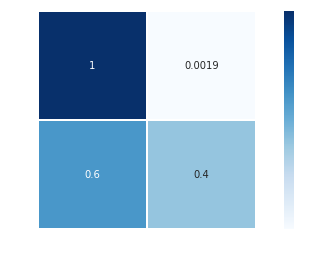

In [13]:
########## CONFUSION MATRIX

# construct confusion matrx
cm = confusion_matrix(y, np.round(preds_oof))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# plot matrix
fig, ax = plt.subplots(figsize = (10, 4))
sns.heatmap(cm, cmap = 'Blues', annot = True, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

# SUBMISSION

In [14]:
# file name
model = 'lgb_v9g'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf
name

'lgb_v9g_93890'

In [15]:
# export OOF preds
oof = pd.DataFrame({'TransactionID': full_train['TransactionID'], 'isFraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,TransactionID,isFraud
0,2987000,0.009104
1,2987001,0.002511
2,2987002,0.001811
3,2987003,0.002931
4,2987004,0.000605


In [16]:
# export submission
sub = pd.DataFrame({'TransactionID': full_test['TransactionID'], 'isFraud': preds_test})
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,TransactionID,isFraud
0,3663549,0.000522
1,3663550,0.001077
2,3663551,0.000741
3,3663552,0.000351
4,3663553,0.000622


In [17]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
sub  = sub.sort_values('TransactionID')
best = pd.read_csv("../submissions/BlendSolution.csv")
best = best.sort_values('TransactionID')
spearmanr(sub.isFraud, best.isFraud)

SpearmanrResult(correlation=0.783196413839036, pvalue=0.0)